### Setup

In [1]:
# imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from joblib import Parallel, delayed
from sklearn.utils.class_weight import compute_sample_weight
import time
import pickle
import shap; shap.initjs()

### Exploratory data analysis

*Dataset format*

In [2]:
# load data
diabetes_data = pd.read_csv("../data/diabetes_binary_health_indicators_BRFSS2015.csv")

print(f"DATA HEAD:\n{diabetes_data.head()}\n")
print(f"DATA COLUMNS:\n{list(diabetes_data.columns)}\n")
print(f"DATA MISSING VALUES:\n{diabetes_data.isna().any()}")

DATA HEAD:
   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0

In [3]:
print(f"ROWS: {diabetes_data.shape[0]}")
print(f"COLUMNS: {diabetes_data.shape[1]}")

ROWS: 253680
COLUMNS: 22


In [4]:
for i, col in enumerate(diabetes_data.columns):
    print(f"COLUMN NAME: {col} | COLUMN DTYPE: {diabetes_data.dtypes.iloc[i]}")

COLUMN NAME: Diabetes_binary | COLUMN DTYPE: float64
COLUMN NAME: HighBP | COLUMN DTYPE: float64
COLUMN NAME: HighChol | COLUMN DTYPE: float64
COLUMN NAME: CholCheck | COLUMN DTYPE: float64
COLUMN NAME: BMI | COLUMN DTYPE: float64
COLUMN NAME: Smoker | COLUMN DTYPE: float64
COLUMN NAME: Stroke | COLUMN DTYPE: float64
COLUMN NAME: HeartDiseaseorAttack | COLUMN DTYPE: float64
COLUMN NAME: PhysActivity | COLUMN DTYPE: float64
COLUMN NAME: Fruits | COLUMN DTYPE: float64
COLUMN NAME: Veggies | COLUMN DTYPE: float64
COLUMN NAME: HvyAlcoholConsump | COLUMN DTYPE: float64
COLUMN NAME: AnyHealthcare | COLUMN DTYPE: float64
COLUMN NAME: NoDocbcCost | COLUMN DTYPE: float64
COLUMN NAME: GenHlth | COLUMN DTYPE: float64
COLUMN NAME: MentHlth | COLUMN DTYPE: float64
COLUMN NAME: PhysHlth | COLUMN DTYPE: float64
COLUMN NAME: DiffWalk | COLUMN DTYPE: float64
COLUMN NAME: Sex | COLUMN DTYPE: float64
COLUMN NAME: Age | COLUMN DTYPE: float64
COLUMN NAME: Education | COLUMN DTYPE: float64
COLUMN NAME: Inco

*Target variable*

Value counts:
Diabetes_binary
Non-Diabetic      218334
(Pre-)Diabetic     35346
Name: count, dtype: int64

Class proportions:
Diabetes_binary
Non-Diabetic      0.860667
(Pre-)Diabetic    0.139333
Name: count, dtype: float64



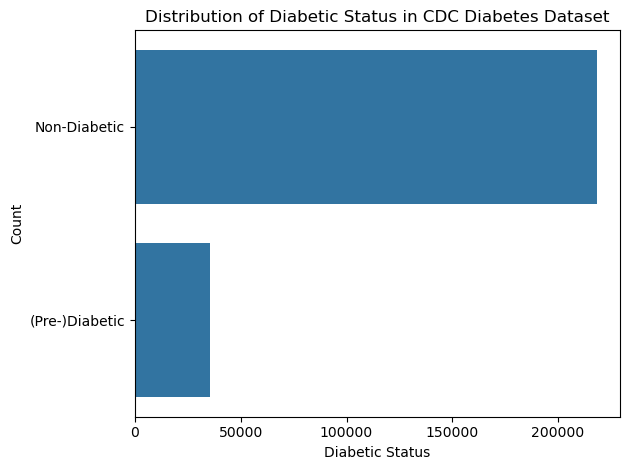

In [5]:
X = diabetes_data.drop(columns=["Diabetes_binary"])
y = diabetes_data["Diabetes_binary"]
    
y_vis = y.replace({0 : "Non-Diabetic", 1 : "(Pre-)Diabetic"})
counts = y_vis.value_counts()
print(f"Value counts:\n{counts}\n")
print(f"Class proportions:\n{counts / len(y_vis)}\n")

sns.countplot(data=y_vis)
plt.title("Distribution of Diabetic Status in CDC Diabetes Dataset")
plt.xlabel("Diabetic Status")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../figures/target.png", dpi=300)
plt.show()
plt.close()

*Features*

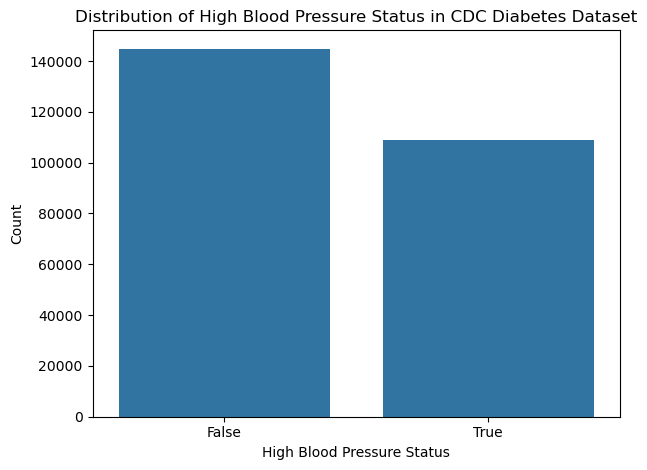

COUNTS:
HighBP
False    144851
True     108829
Name: count, dtype: int64
PROPORTIONS:
HighBP
False    0.570999
True     0.429001
Name: count, dtype: float64


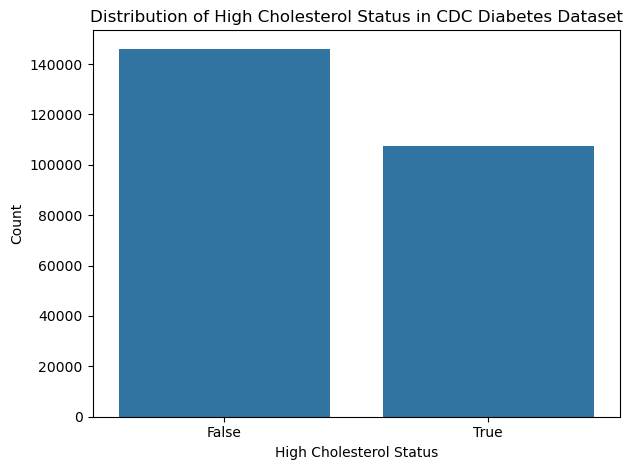

COUNTS:
HighChol
False    146089
True     107591
Name: count, dtype: int64
PROPORTIONS:
HighChol
False    0.575879
True     0.424121
Name: count, dtype: float64


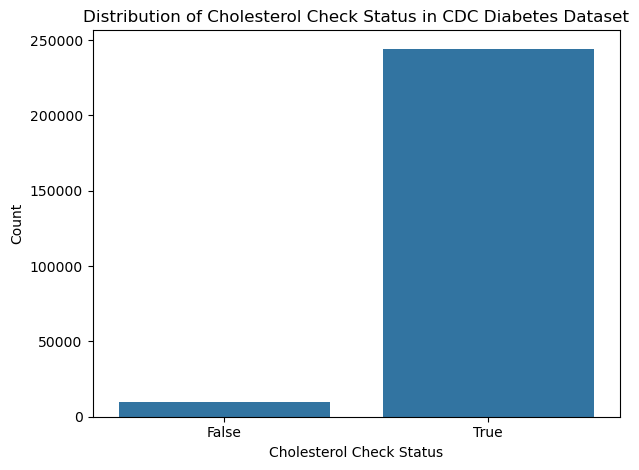

COUNTS:
CholCheck
True     244210
False      9470
Name: count, dtype: int64
PROPORTIONS:
CholCheck
True     0.96267
False    0.03733
Name: count, dtype: float64


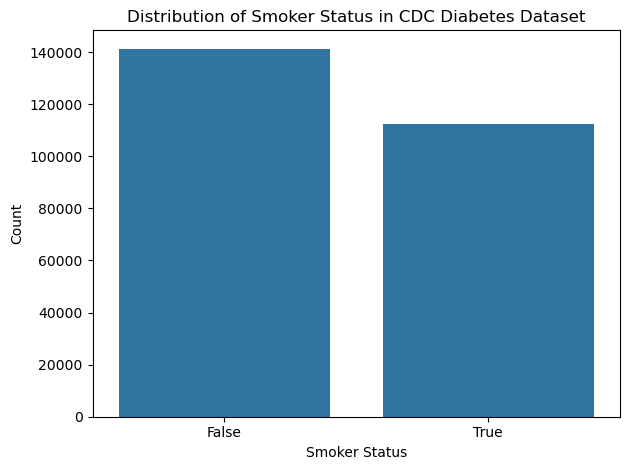

COUNTS:
Smoker
False    141257
True     112423
Name: count, dtype: int64
PROPORTIONS:
Smoker
False    0.556831
True     0.443169
Name: count, dtype: float64


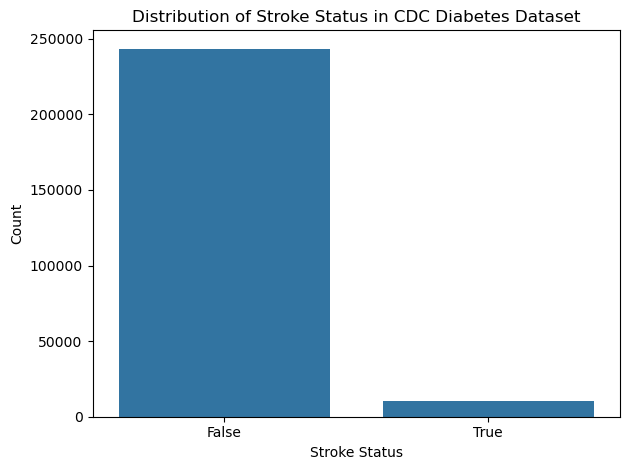

COUNTS:
Stroke
False    243388
True      10292
Name: count, dtype: int64
PROPORTIONS:
Stroke
False    0.959429
True     0.040571
Name: count, dtype: float64


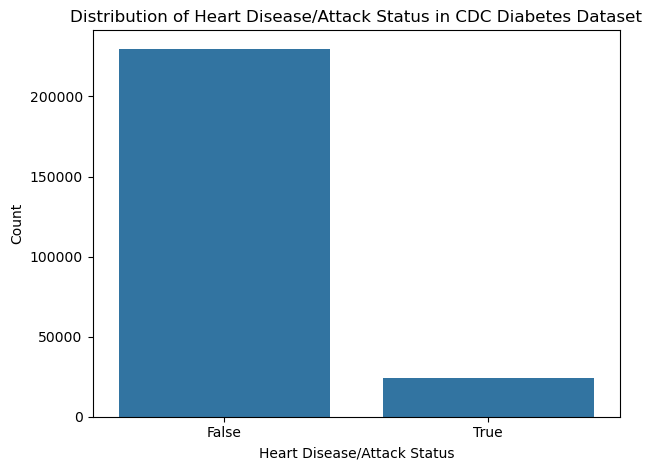

COUNTS:
HeartDiseaseorAttack
False    229787
True      23893
Name: count, dtype: int64
PROPORTIONS:
HeartDiseaseorAttack
False    0.905814
True     0.094186
Name: count, dtype: float64


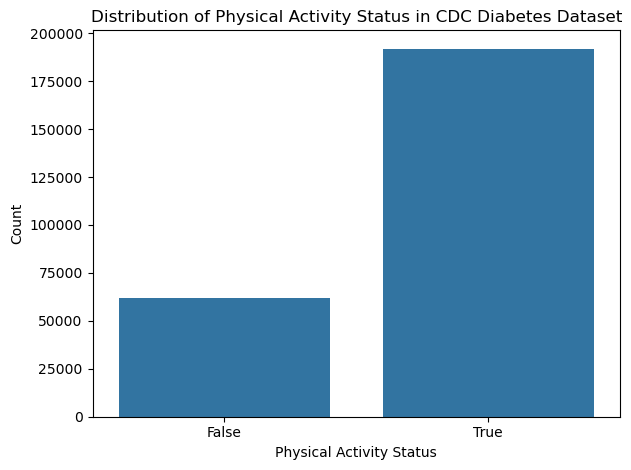

COUNTS:
PhysActivity
True     191920
False     61760
Name: count, dtype: int64
PROPORTIONS:
PhysActivity
True     0.756544
False    0.243456
Name: count, dtype: float64


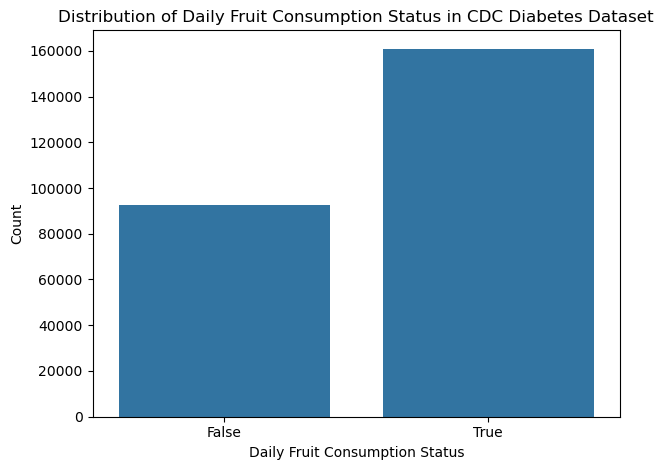

COUNTS:
Fruits
True     160898
False     92782
Name: count, dtype: int64
PROPORTIONS:
Fruits
True     0.634256
False    0.365744
Name: count, dtype: float64


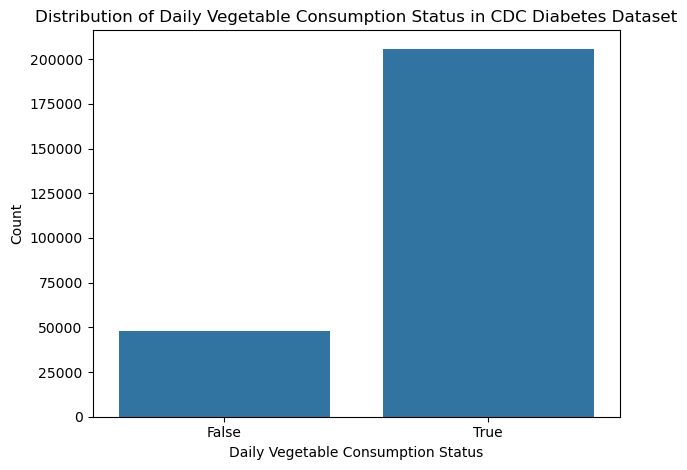

COUNTS:
Veggies
True     205841
False     47839
Name: count, dtype: int64
PROPORTIONS:
Veggies
True     0.81142
False    0.18858
Name: count, dtype: float64


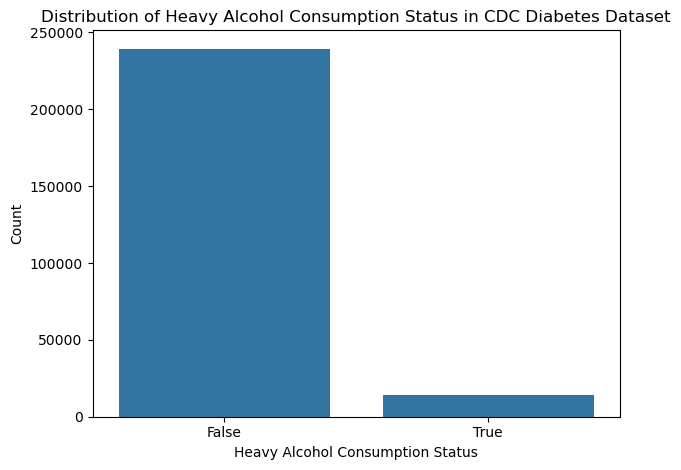

COUNTS:
HvyAlcoholConsump
False    239424
True      14256
Name: count, dtype: int64
PROPORTIONS:
HvyAlcoholConsump
False    0.943803
True     0.056197
Name: count, dtype: float64


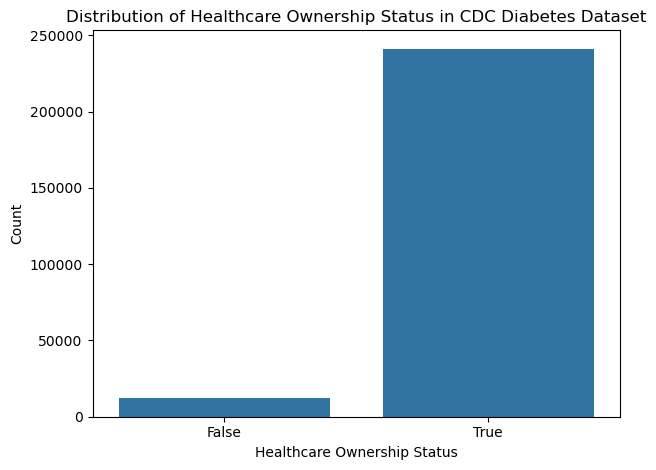

COUNTS:
AnyHealthcare
True     241263
False     12417
Name: count, dtype: int64
PROPORTIONS:
AnyHealthcare
True     0.951053
False    0.048947
Name: count, dtype: float64


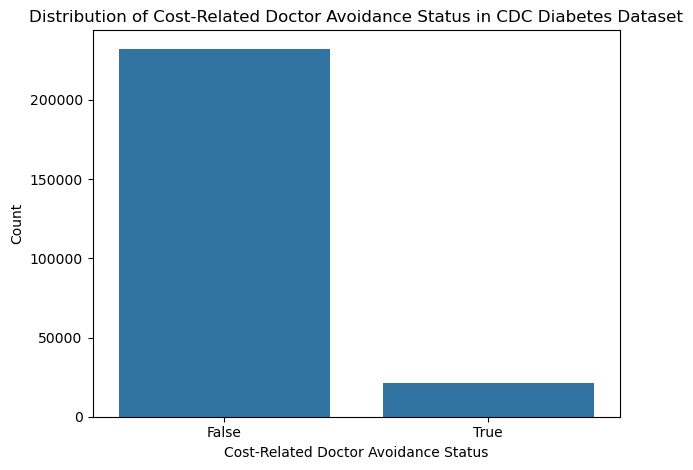

COUNTS:
NoDocbcCost
False    232326
True      21354
Name: count, dtype: int64
PROPORTIONS:
NoDocbcCost
False    0.915823
True     0.084177
Name: count, dtype: float64


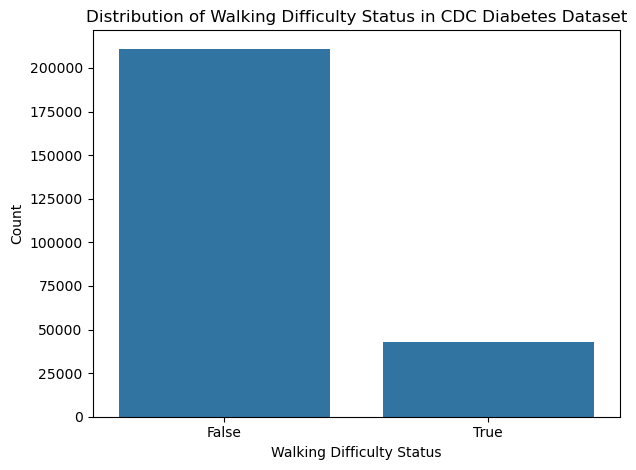

COUNTS:
DiffWalk
False    211005
True      42675
Name: count, dtype: int64
PROPORTIONS:
DiffWalk
False    0.831776
True     0.168224
Name: count, dtype: float64


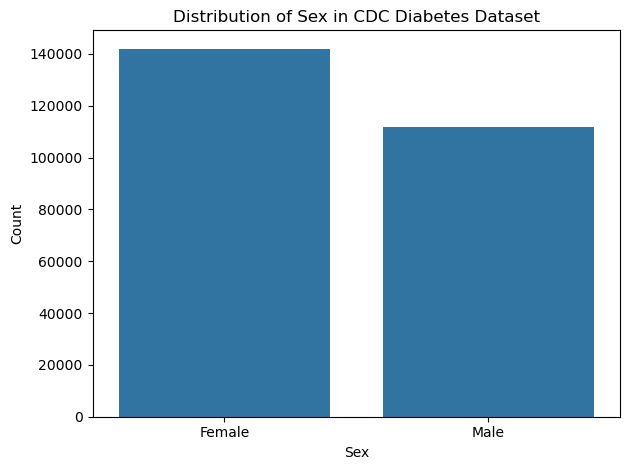

COUNTS:
Sex
Female    141974
Male      111706
Name: count, dtype: int64
PROPORTIONS:
Sex
Female    0.559658
Male      0.440342
Name: count, dtype: float64


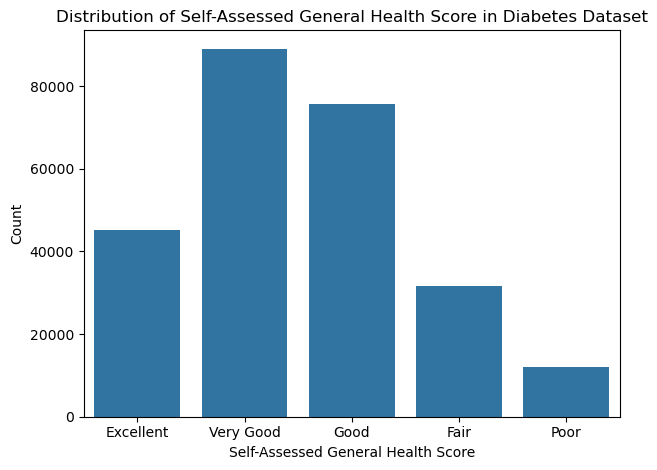

SUMMARY STATISTICS:
count    253680.000000
mean          2.511392
std           1.068477
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           5.000000
Name: GenHlth, dtype: float64


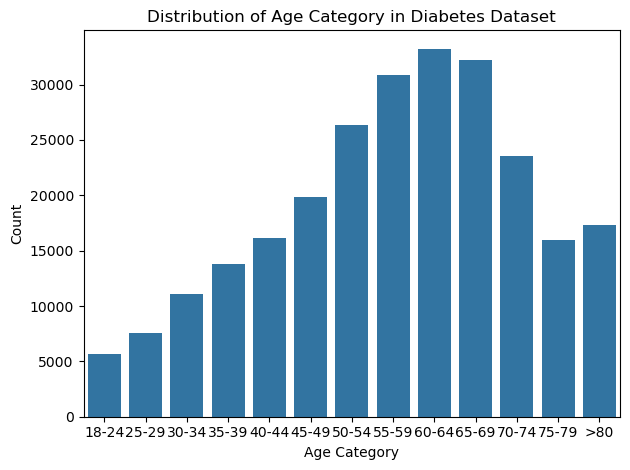

SUMMARY STATISTICS:
count    253680.000000
mean          8.032119
std           3.054220
min           1.000000
25%           6.000000
50%           8.000000
75%          10.000000
max          13.000000
Name: Age, dtype: float64


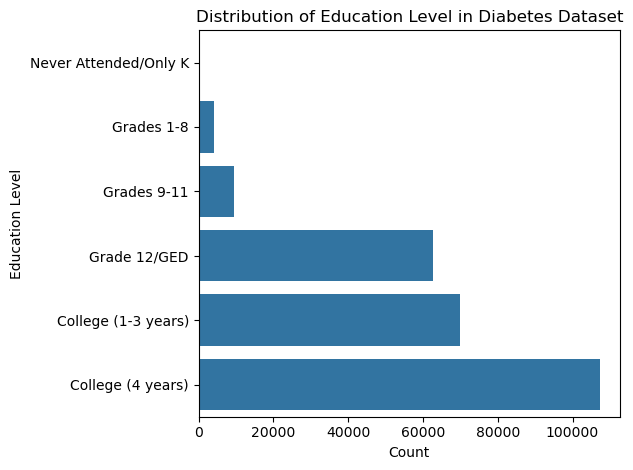

SUMMARY STATISTICS:
count    253680.000000
mean          5.050434
std           0.985774
min           1.000000
25%           4.000000
50%           5.000000
75%           6.000000
max           6.000000
Name: Education, dtype: float64


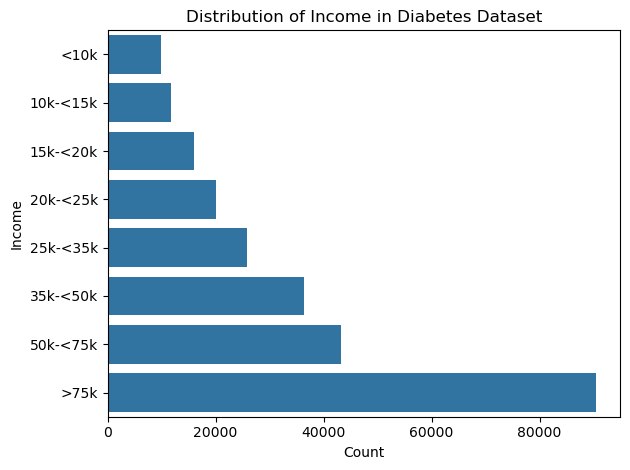

SUMMARY STATISTICS:
count    253680.000000
mean          6.053875
std           2.071148
min           1.000000
25%           5.000000
50%           7.000000
75%           8.000000
max           8.000000
Name: Income, dtype: float64


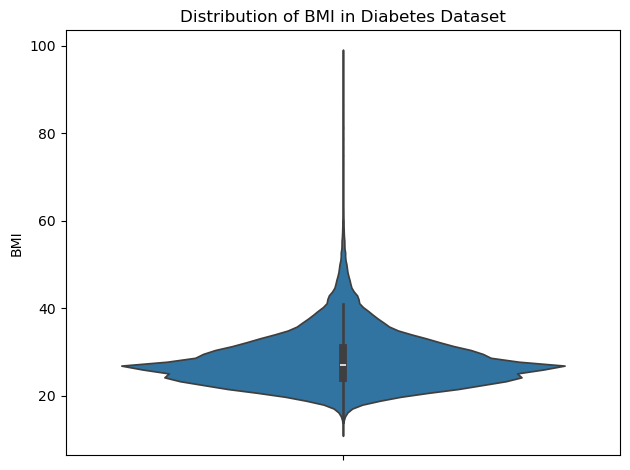

SUMMARY STATISTICS:
count    253680.000000
mean         28.382364
std           6.608694
min          12.000000
25%          24.000000
50%          27.000000
75%          31.000000
max          98.000000
Name: BMI, dtype: float64


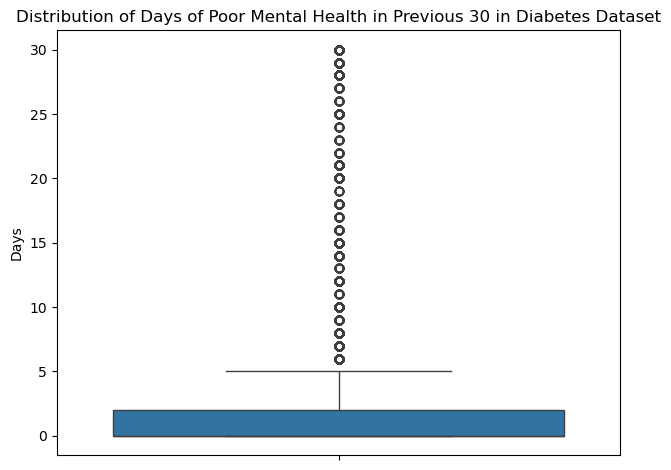

SUMMARY STATISTICS:
count    253680.000000
mean          3.184772
std           7.412847
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          30.000000
Name: MentHlth, dtype: float64


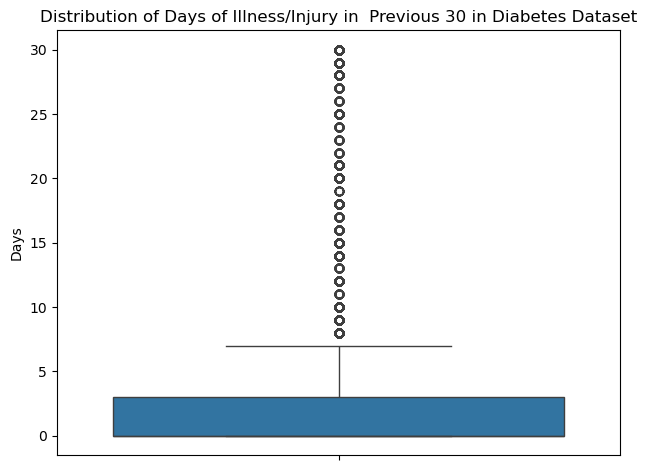

SUMMARY STATISTICS:
count    253680.000000
mean          4.242081
std           8.717951
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          30.000000
Name: PhysHlth, dtype: float64


In [6]:
# individual features
# HighBP
high_bp_vis = diabetes_data["HighBP"].astype(bool)
sns.barplot(data=high_bp_vis.value_counts())
plt.title("Distribution of High Blood Pressure Status in CDC Diabetes Dataset")
plt.xlabel("High Blood Pressure Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"COUNTS:\n{high_bp_vis.value_counts()}")
print(f"PROPORTIONS:\n{high_bp_vis.value_counts() / len(high_bp_vis)}")

# HighChol
high_chol_vis = diabetes_data["HighChol"].astype(bool)
sns.barplot(data=high_chol_vis.value_counts())
plt.title("Distribution of High Cholesterol Status in CDC Diabetes Dataset")
plt.xlabel("High Cholesterol Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"COUNTS:\n{high_chol_vis.value_counts()}")
print(f"PROPORTIONS:\n{high_chol_vis.value_counts() / len(high_chol_vis)}")

# CholCheck
chol_check_vis = diabetes_data["CholCheck"].astype(bool)
sns.barplot(data=chol_check_vis.value_counts())
plt.title("Distribution of Cholesterol Check Status in CDC Diabetes Dataset")
plt.xlabel("Cholesterol Check Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"COUNTS:\n{chol_check_vis.value_counts()}")
print(f"PROPORTIONS:\n{chol_check_vis.value_counts() / len(chol_check_vis)}")

# Smoker
smoker_vis = diabetes_data["Smoker"].astype(bool)
sns.barplot(data=smoker_vis.value_counts())
plt.title("Distribution of Smoker Status in CDC Diabetes Dataset")
plt.xlabel("Smoker Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"COUNTS:\n{smoker_vis.value_counts()}")
print(f"PROPORTIONS:\n{smoker_vis.value_counts() / len(smoker_vis)}")

# Stroke
stroke_vis = diabetes_data["Stroke"].astype(bool)
sns.barplot(data=stroke_vis.value_counts())
plt.title("Distribution of Stroke Status in CDC Diabetes Dataset")
plt.xlabel("Stroke Status")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../figures/stroke.png", dpi=300)
plt.show()
plt.close()
print(f"COUNTS:\n{stroke_vis.value_counts()}")
print(f"PROPORTIONS:\n{stroke_vis.value_counts() / len(stroke_vis)}")

# HeartDiseaseorAttack
hdoa_vis = diabetes_data["HeartDiseaseorAttack"].astype(bool)
sns.barplot(data=hdoa_vis.value_counts())
plt.title("Distribution of Heart Disease/Attack Status in CDC Diabetes Dataset")
plt.xlabel("Heart Disease/Attack Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"COUNTS:\n{hdoa_vis.value_counts()}")
print(f"PROPORTIONS:\n{hdoa_vis.value_counts() / len(hdoa_vis)}")

# PhysActivity
phys_activity_vis = diabetes_data["PhysActivity"].astype(bool)
sns.barplot(data=phys_activity_vis.value_counts())
plt.title("Distribution of Physical Activity Status in CDC Diabetes Dataset")
plt.xlabel("Physical Activity Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"COUNTS:\n{phys_activity_vis.value_counts()}")
print(f"PROPORTIONS:\n{phys_activity_vis.value_counts() / len(phys_activity_vis)}")

# Fruits
fruits_vis = diabetes_data["Fruits"].astype(bool)
sns.barplot(data=fruits_vis.value_counts())
plt.title("Distribution of Daily Fruit Consumption Status in CDC Diabetes Dataset")
plt.xlabel("Daily Fruit Consumption Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"COUNTS:\n{fruits_vis.value_counts()}")
print(f"PROPORTIONS:\n{fruits_vis.value_counts() / len(fruits_vis)}")

# Veggies
veggies_vis = diabetes_data["Veggies"].astype(bool)
sns.barplot(data=veggies_vis.value_counts())
plt.title("Distribution of Daily Vegetable Consumption Status in CDC Diabetes Dataset")
plt.xlabel("Daily Vegetable Consumption Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"COUNTS:\n{veggies_vis.value_counts()}")
print(f"PROPORTIONS:\n{veggies_vis.value_counts() / len(veggies_vis)}")

# HvyAlcoholConsump
alc_vis = diabetes_data["HvyAlcoholConsump"].astype(bool)
sns.barplot(data=alc_vis.value_counts())
plt.title("Distribution of Heavy Alcohol Consumption Status in CDC Diabetes Dataset")
plt.xlabel("Heavy Alcohol Consumption Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"COUNTS:\n{alc_vis.value_counts()}")
print(f"PROPORTIONS:\n{alc_vis.value_counts() / len(alc_vis)}")

# AnyHealthcare
health_vis = diabetes_data["AnyHealthcare"].astype(bool)
sns.barplot(data=health_vis.value_counts())
plt.title("Distribution of Healthcare Ownership Status in CDC Diabetes Dataset")
plt.xlabel("Healthcare Ownership Status")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../figures/health.png", dpi=300)
plt.show()
plt.close()
print(f"COUNTS:\n{health_vis.value_counts()}")
print(f"PROPORTIONS:\n{health_vis.value_counts() / len(health_vis)}")

# NoDocbcCost
no_doc_vis = diabetes_data["NoDocbcCost"].astype(bool)
sns.barplot(data=no_doc_vis.value_counts())
plt.title("Distribution of Cost-Related Doctor Avoidance Status in CDC Diabetes Dataset")
plt.xlabel("Cost-Related Doctor Avoidance Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"COUNTS:\n{no_doc_vis.value_counts()}")
print(f"PROPORTIONS:\n{no_doc_vis.value_counts() / len(no_doc_vis)}")

# DiffWalk
diff_walks_vis = diabetes_data["DiffWalk"].astype(bool)
sns.barplot(data=diff_walks_vis.value_counts())
plt.title("Distribution of Walking Difficulty Status in CDC Diabetes Dataset")
plt.xlabel("Walking Difficulty Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"COUNTS:\n{diff_walks_vis.value_counts()}")
print(f"PROPORTIONS:\n{diff_walks_vis.value_counts() / len(diff_walks_vis)}")

# Sex
sex_vis = diabetes_data["Sex"].replace({0 : "Female", 1 : "Male"})
sns.barplot(data=sex_vis.value_counts())
plt.title("Distribution of Sex in CDC Diabetes Dataset")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"COUNTS:\n{sex_vis.value_counts()}")
print(f"PROPORTIONS:\n{sex_vis.value_counts() / len(sex_vis)}")


# GenHlth
genhlth_vals = [
    "Excellent",
    "Very Good",
    "Good",
    "Fair",
    "Poor"
]

genhlth_vis = diabetes_data["GenHlth"].astype(int)
to_plot = genhlth_vis.value_counts().sort_index()
to_plot.index = genhlth_vals
sns.barplot(data=to_plot)
plt.title("Distribution of Self-Assessed General Health Score in Diabetes Dataset")
plt.xlabel("Self-Assessed General Health Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"SUMMARY STATISTICS:\n{genhlth_vis.describe()}")

# Age
age_vals = [
    "18-24",
    "25-29",
    "30-34",
    "35-39",
    "40-44",
    "45-49",
    "50-54",
    "55-59",
    "60-64",
    "65-69",
    "70-74",
    "75-79",
    ">80"
]

age_vis = diabetes_data["Age"].astype(int)
to_plot = age_vis.value_counts().sort_index()
to_plot.index = age_vals
sns.barplot(data=to_plot)
plt.title("Distribution of Age Category in Diabetes Dataset")
plt.xlabel("Age Category")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../figures/age.png", dpi=300)
plt.show()
plt.close()
print(f"SUMMARY STATISTICS:\n{age_vis.describe()}")

# Education
edu_vals = [
    "Never Attended/Only K",
    "Grades 1-8",
    "Grades 9-11",
    "Grade 12/GED",
    "College (1-3 years)",
    "College (4 years)"
]

edu_vis = diabetes_data["Education"].astype(int)
to_plot = edu_vis.value_counts().sort_index()
to_plot.index = edu_vals
sns.barplot(data=to_plot, orient="h")
plt.title("Distribution of Education Level in Diabetes Dataset")
plt.ylabel("Education Level")
plt.xlabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"SUMMARY STATISTICS:\n{edu_vis.describe()}")

# Income
income_vals = [
    "<10k",
    "10k-<15k",
    "15k-<20k",
    "20k-<25k",
    "25k-<35k",
    "35k-<50k",
    "50k-<75k",
    ">75k"
]

income_vis = diabetes_data["Income"].astype(int)
to_plot = income_vis.value_counts().sort_index()
to_plot.index = income_vals
sns.barplot(data=to_plot, orient="h")
plt.title("Distribution of Income in Diabetes Dataset")
plt.ylabel("Income")
plt.xlabel("Count")
plt.tight_layout()
plt.show()
plt.close()
print(f"SUMMARY STATISTICS:\n{income_vis.describe()}")

# BMI
bmi_vis = diabetes_data["BMI"]
bmi_bins = np.arange(0, 102, 3)
sns.violinplot(bmi_vis)
plt.title("Distribution of BMI in Diabetes Dataset")
plt.ylabel("BMI")
plt.tight_layout()
plt.savefig("../figures/bmi.png", dpi=300)
plt.show()
plt.close()
print(f"SUMMARY STATISTICS:\n{bmi_vis.describe()}")

# MentHlth
ment_vis = diabetes_data["MentHlth"]
sns.boxplot(ment_vis)
plt.title("Distribution of Days of Poor Mental Health in Previous 30 in Diabetes Dataset")
plt.ylabel("Days")
plt.tight_layout()
plt.show()
plt.close()
print(f"SUMMARY STATISTICS:\n{ment_vis.describe()}")

# PhysHlth
phys_vis = diabetes_data["PhysHlth"]
sns.boxplot(phys_vis)
plt.title("Distribution of Days of Illness/Injury in  Previous 30 in Diabetes Dataset")
plt.ylabel("Days")
plt.tight_layout()
plt.show()
plt.close()
print(f"SUMMARY STATISTICS:\n{phys_vis.describe()}")

*Feature combinations*

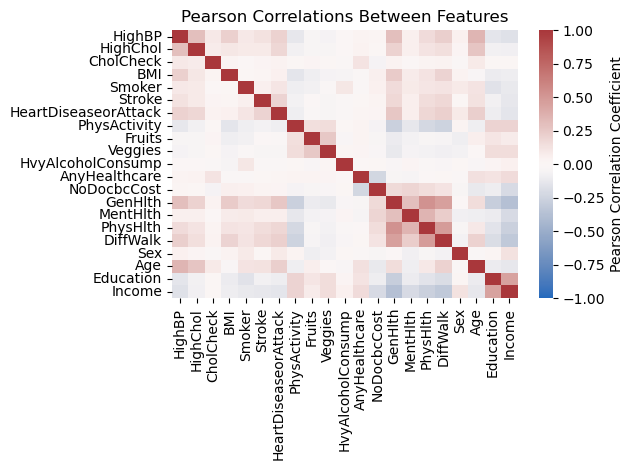

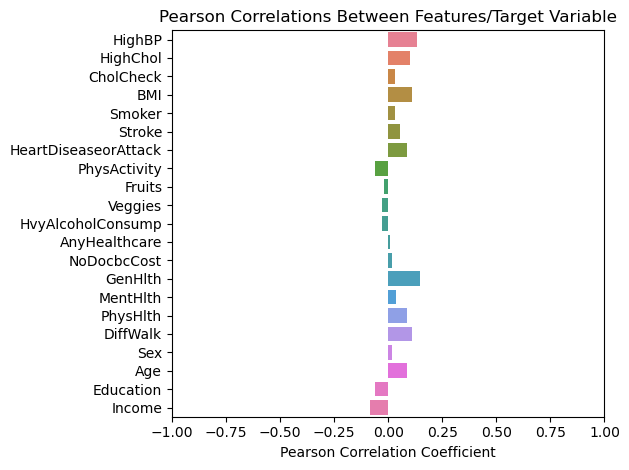

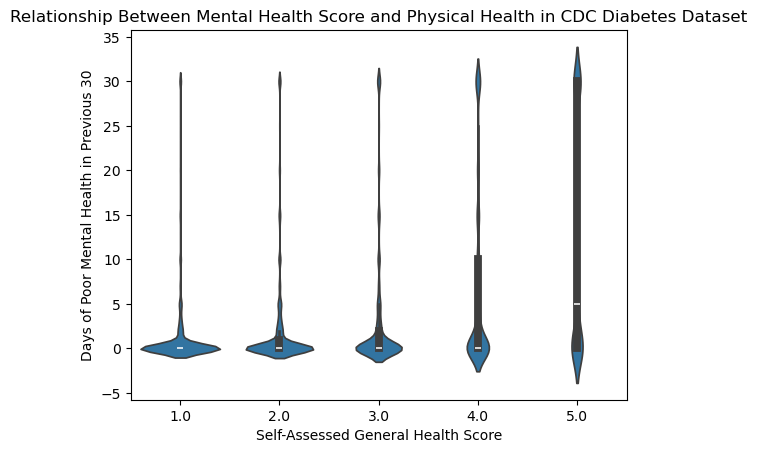

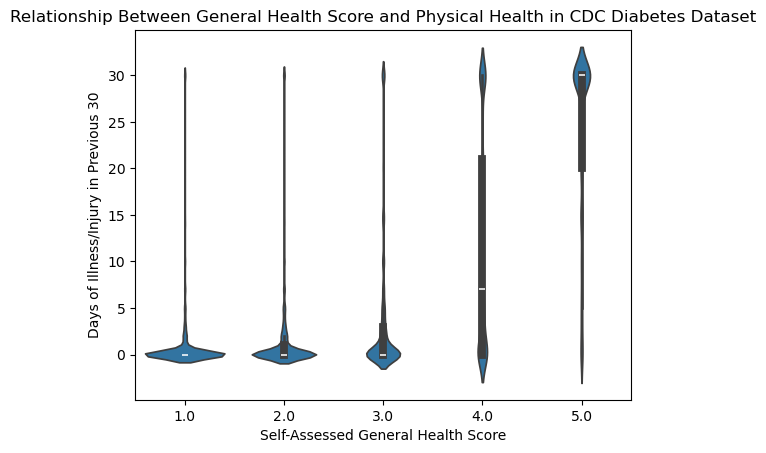

In [7]:
# combinations of features
# analyze correlation between all features
sns.heatmap(X.corr(), cmap="vlag", vmin=-1, vmax=1, cbar_kws={'label': 'Pearson Correlation Coefficient'})
plt.title("Pearson Correlations Between Features")
plt.tight_layout()
plt.savefig("../figures/feature_corr.png", dpi=300)
plt.show()
plt.close()

# analyze correlation with target variable
diabetes_data_corr = pd.DataFrame(columns=X.columns)
for feature in X.columns:
    diabetes_data_corr[feature] = pearsonr(
        diabetes_data[feature],
        diabetes_data["Diabetes_binary"]
    )
sns.barplot(diabetes_data_corr, orient="h", errorbar=None)
plt.xlim((-1,1))
plt.xlabel("Pearson Correlation Coefficient")
plt.title("Pearson Correlations Between Features/Target Variable")
plt.tight_layout()
plt.savefig("../figures/target_corr.png", dpi=300)
plt.show()
plt.close()

# relationship between general and mental health
sns.violinplot(data=X, x="GenHlth", y="MentHlth")
plt.title("Relationship Between Mental Health Score and Physical Health in CDC Diabetes Dataset")
plt.xlabel("Self-Assessed General Health Score")
plt.ylabel("Days of Poor Mental Health in Previous 30")
plt.show()
plt.close()

# relationship between general and physical health
sns.violinplot(data=X, x="GenHlth", y="PhysHlth")
plt.title("Relationship Between General Health Score and Physical Health in CDC Diabetes Dataset")
plt.xlabel("Self-Assessed General Health Score")
plt.ylabel("Days of Illness/Injury in Previous 30")
plt.show()
plt.close()

### Model training

*Logistic regression*

In [8]:
random_states = [7, 42, 65, 2004, 2026]
preprocessor = ColumnTransformer(transformers=[("ss", StandardScaler(), X.columns)])
logreg_params = {
    "logisticregression__C" : np.logspace(-3, 3, 7),
    "logisticregression__l1_ratio" : np.linspace(0.1, 0.9, 5),
}

test_scores = []
cv_scores = []
logreg_results = {
    "seed" : [],
    "cv_scores" : [],
    "test_scores" : [],
    "models" : [],
    "results" : [],
    "params" : []
}
for rs in random_states:
    print(f"Processing state {rs}...")
    ti = time.time()

    # add random state to results
    logreg_results["seed"].append(rs)

    # split into cross-validation (80%) and testing (20%) sets
    X_cv, X_test, y_cv, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rs)

    # initialize classifier
    clf = LogisticRegression(class_weight="balanced", max_iter=10000, penalty="elasticnet", solver="saga", random_state=rs)

    # create pipeline with preprocessor
    pipe = make_pipeline(preprocessor, clf)

    # initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=rs)

    # initialize GridSearchCV
    gscv = GridSearchCV(pipe, param_grid=logreg_params, cv=skf, scoring="f1", n_jobs=-1, return_train_score=True)

    # tune hyperparameters
    gscv.fit(X_cv, y_cv)

    # get best CV/test scores
    cv_score = gscv.best_score_
    test_score = f1_score(y_test, gscv.predict(X_test))

    # store CV results for this seed
    logreg_results["results"].append(pd.DataFrame(gscv.cv_results_))

    # store scores and models for this seed
    logreg_results["test_scores"].append(test_score)
    logreg_results["cv_scores"].append(cv_score)
    logreg_results["models"].append(gscv.best_estimator_)
    logreg_results["params"].append(gscv.best_params_)
    print(f"...took {time.time() - ti} seconds")

with open("../results/logreg_results.pkl", "wb") as f:
    pickle.dump(logreg_results, f)
print("Saved results!")

Processing state 7...
...took 143.4973907470703 seconds
Processing state 42...
...took 97.83393549919128 seconds
Processing state 65...
...took 100.70654296875 seconds
Processing state 2004...
...took 76.91199588775635 seconds
Processing state 2026...
...took 80.13443279266357 seconds
Saved results!


In [9]:
test_scores, cv_scores = logreg_results["test_scores"], logreg_results["cv_scores"]
print(f"Test results for logistic regression: f1 score = {np.mean(test_scores):.3f} +/- {np.std(test_scores):.3f}")
print(f"CV results for logistic regression: f1 score = {np.mean(cv_scores):.3f} +/- {np.std(cv_scores):.3f}")

Test results for logistic regression: f1 score = 0.442 +/- 0.002
CV results for logistic regression: f1 score = 0.443 +/- 0.001


*Random Forest*

In [10]:
random_states = [7, 42, 65, 2004, 2026]
preprocessor = ColumnTransformer(transformers=[("ss", StandardScaler(), X.columns)])
rf_params = {
    "randomforestclassifier__max_features" : np.linspace(0.1, 0.9, 5),
    "randomforestclassifier__max_depth" : np.array([3, 5, 10, 30])
}

test_scores = []
cv_scores = []
rf_results = {
    "seed" : [],
    "cv_scores" : [],
    "test_scores" : [],
    "models" : [],
    "results" : [],
    "params" : []
}
for rs in random_states:
    print(f"Processing state {rs}...")
    ti = time.time()

    # add random state to results
    rf_results["seed"].append(rs)

    # split into cross-validation (80%) and testing (20%) sets
    X_cv, X_test, y_cv, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rs)

    # initialize classifier
    clf = RandomForestClassifier(random_state=rs, class_weight="balanced")

    # create pipeline with preprocessor
    pipe = make_pipeline(preprocessor, clf)

    # initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=rs)

    # initialize GridSearchCV
    gscv = GridSearchCV(pipe, param_grid=rf_params, cv=skf, scoring="f1", n_jobs=-1, return_train_score=True)

    # tune hyperparameters
    gscv.fit(X_cv, y_cv)

    # get best CV/test scores
    cv_score = gscv.best_score_
    test_score = f1_score(y_test, gscv.predict(X_test))

    # store CV results for this seed
    rf_results["results"].append(pd.DataFrame(gscv.cv_results_))

    # store scores and models for this seed
    rf_results["test_scores"].append(test_score)
    rf_results["cv_scores"].append(cv_score)
    rf_results["models"].append(gscv.best_estimator_)
    rf_results["params"].append(gscv.best_params_)

    print(f"...took {time.time() - ti} seconds")

with open("../results/rf_results.pkl", "wb") as f:
    pickle.dump(rf_results, f)
print("Saved results!")

Processing state 7...
...took 529.8576145172119 seconds
Processing state 42...
...took 611.7347056865692 seconds
Processing state 65...
...took 524.5058467388153 seconds
Processing state 2004...
...took 550.6224024295807 seconds
Processing state 2026...
...took 559.0186789035797 seconds
Saved results!


In [11]:
test_scores, cv_scores = rf_results["test_scores"], rf_results["cv_scores"]
print(f"Test results for random forest: f1 score = {np.mean(test_scores):.3f} +/- {np.std(test_scores):.3f}")
print(f"CV results for random forest: f1 score = {np.mean(cv_scores):.3f} +/- {np.std(cv_scores):.3f}")

Test results for random forest: f1 score = 0.445 +/- 0.002
CV results for random forest: f1 score = 0.447 +/- 0.000


*Decision Tree*

In [12]:
random_states = [7, 42, 65, 2004, 2026]
preprocessor = ColumnTransformer(transformers=[("ss", StandardScaler(), X.columns)])
dt_params = {
    "decisiontreeclassifier__max_features" : np.linspace(0.1, 0.9, 5),
    "decisiontreeclassifier__max_depth" : np.array([3, 5, 10, 30]),
}

test_scores = []
cv_scores = []
dt_results = {
    "seed" : [],
    "cv_scores" : [],
    "test_scores" : [],
    "models" : [],
    "results" : [],
    "params" : []
}
for rs in random_states:
    print(f"Processing state {rs}...")
    ti = time.time()

    # add random state to results
    dt_results["seed"].append(rs)

    # split into cross-validation (80%) and testing (20%) sets
    X_cv, X_test, y_cv, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rs)

    # initialize classifier
    clf = DecisionTreeClassifier(class_weight="balanced", random_state=rs)

    # create pipeline with preprocessor
    pipe = make_pipeline(preprocessor, clf)

    # initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=rs)

    # initialize GridSearchCV
    gscv = GridSearchCV(pipe, param_grid=dt_params, cv=skf, scoring="f1", n_jobs=-1, return_train_score=True)

    # tune hyperparameters
    gscv.fit(X_cv, y_cv)

    # get best CV/test scores
    cv_score = gscv.best_score_
    test_score = f1_score(y_test, gscv.predict(X_test))

    # store CV results for this seed
    dt_results["results"].append(pd.DataFrame(gscv.cv_results_))

    # store scores and models for this seed
    dt_results["test_scores"].append(test_score)
    dt_results["cv_scores"].append(cv_score)
    dt_results["models"].append(gscv.best_estimator_)
    dt_results["params"].append(gscv.best_params_)

    print(f"...took {time.time() - ti} seconds")

with open("../results/dt_results.pkl", "wb") as f:
    pickle.dump(dt_results, f)
print("Saved results!")

Processing state 7...
...took 15.279844760894775 seconds
Processing state 42...
...took 14.675900220870972 seconds
Processing state 65...
...took 14.92818284034729 seconds
Processing state 2004...
...took 15.44526982307434 seconds
Processing state 2026...
...took 15.640763521194458 seconds
Saved results!


In [13]:
test_scores, cv_scores = dt_results["test_scores"], dt_results["cv_scores"]
print(f"Test results for decision tree: f1 score = {np.mean(test_scores):.3f} +/- {np.std(test_scores):.3f}")
print(f"CV results for decision tree: f1 score = {np.mean(cv_scores):.3f} +/- {np.std(cv_scores):.3f}")

Test results for decision tree: f1 score = 0.429 +/- 0.003
CV results for decision tree: f1 score = 0.428 +/- 0.001


*XGBoost*

In [14]:
random_states = [7, 42, 65, 2004, 2026]
xgb_es_params = {
    "max_depth" : np.array([3, 5, 10, 30, 50]),
    "reg_lambda" : np.logspace(-3, 3, 7)
}

test_scores = []
cv_scores = []
xgb_es_results = {
    "seed" : [],
    "cv_scores" : [],
    "test_scores" : [],
    "models" : [],
    "results" : [],
    "params" : []
}

def eval_xgb_param(X_cv, y_cv, cv, param, rs):
    """
    GridSearchCV-like function that allows parallelization
    of XGBoost parameter grid search with early stopping 
    using k-fold cross-validation.
    """

    train_scores = []
    val_scores = []
    models = []
    # split with cross-validator
    for train_idx, val_idx in cv.split(X_cv, y_cv):

        # get folds
        X_train, y_train = X_cv.iloc[train_idx], y_cv.iloc[train_idx]
        X_val, y_val = X_cv.iloc[val_idx], y_cv.iloc[val_idx]
        weights = compute_sample_weight("balanced", y_train)

        # preprocess data
        preprocessor = ColumnTransformer(transformers=[("ss", StandardScaler(), X.columns)])
        X_train_prep = preprocessor.fit_transform(X_train)
        X_val_prep = preprocessor.transform(X_val)

        # fit classifier on training data
        clf = XGBClassifier(subsample=0.66, learning_rate=0.03, early_stopping_rounds=50,
                            colsample_bytree=0.9, random_state=rs, **param)
        clf.fit(X_train_prep, y_train, sample_weight=weights, eval_set=[(X_val_prep, y_val)], verbose=False)

        # evaluate on training and validation sets
        train_score = f1_score(y_train, clf.predict(X_train_prep))
        val_score = f1_score(y_val, clf.predict(X_val_prep))

        # add to list
        train_scores.append(train_score)
        val_scores.append(val_score)

        # store model configuration
        models.append((preprocessor, clf))

    # get mean scores across splits
    mean_train_score = np.mean(train_scores)
    mean_val_score = np.mean(val_scores)

    # get best preprocessor/classifier
    best_est = models[np.argmax(val_scores)]

    # finally, the last hyperparameter
    n_est = best_est[1].best_iteration
    return mean_train_score, mean_val_score, best_est, n_est

for rs in random_states:
    print(f"Processing state {rs}...")
    ti = time.time()

    # add random state to results
    xgb_es_results["seed"].append(rs)

    # split into cross-validation (80%) and testing (20%) sets
    X_cv, X_test, y_cv, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rs)

    # make parameter grid
    pg = list(ParameterGrid(xgb_es_params))

    # initialize k-fold
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=rs)

    # paralellize hyperparameter search
    results = Parallel(n_jobs=-1)(delayed(eval_xgb_param)(X_cv, y_cv, skf, param, rs) for param in pg)
    
    # unpack results
    train_scores = [r[0] for r in results]
    val_scores = [r[1] for r in results]
    models = [r[2] for r in results]
    estimators = [r[3] for r in results]

    # find results with best validation score
    best_val_idx = np.argmax(val_scores)
    cv_score = val_scores[best_val_idx]
    preprocessor, clf = models[best_val_idx]
    params = pg[best_val_idx]
    params["n_estimators"] = estimators[best_val_idx]

    # test
    X_test_prep = preprocessor.transform(X_test)
    test_score = f1_score(y_test, clf.predict(X_test_prep))

    cv_results = {
        "train_scores" : train_scores,
        "val_scores" : val_scores,
        "parameters" : pg,
        "estimators" : estimators
    }
    # store CV results for this seed
    xgb_es_results["results"].append(pd.DataFrame(cv_results))

    # store scores and models for this seed
    xgb_es_results["test_scores"].append(test_score)
    xgb_es_results["cv_scores"].append(cv_score)
    xgb_es_results["models"].append((preprocessor, clf))
    xgb_es_results["params"].append(params)

    print(f"...took {time.time() - ti} seconds")

with open("../results/xgb_es_results.pkl", "wb") as f:
    pickle.dump(xgb_es_results, f)
print("Saved results!")

Processing state 7...
...took 420.0112853050232 seconds
Processing state 42...
...took 439.3503301143646 seconds
Processing state 65...
...took 526.462886095047 seconds
Processing state 2004...
...took 602.279545545578 seconds
Processing state 2026...
...took 436.27633261680603 seconds
Saved results!


In [15]:
test_scores, cv_scores = xgb_es_results["test_scores"], xgb_es_results["cv_scores"]
print(f"Test results for XGBoost: f1 score = {np.mean(test_scores):.3f} +/- {np.std(test_scores):.3f}")
print(f"CV results for XGBoost: f1 score = {np.mean(cv_scores):.3f} +/- {np.std(cv_scores):.3f}")

Test results for XGBoost: f1 score = 0.455 +/- 0.002
CV results for XGBoost: f1 score = 0.456 +/- 0.001


*XGBoost Optimization Effort*

In [16]:
random_states = [7, 42, 65, 2004, 2026]
xgb_es_opt_params = {
    "max_depth" : np.array([100, 300]),
    "reg_lambda" : np.array([10])
}

test_scores = []
cv_scores = []
xgb_es_opt_results = {
    "seed" : [],
    "cv_scores" : [],
    "test_scores" : [],
    "models" : [],
    "results" : [],
    "params" : []
}

def eval_xgb_param(X_cv, y_cv, cv, param, rs):
    """
    GridSearchCV-like function that allows parallelization
    of XGBoost parameter grid search with early stopping 
    using k-fold cross-validation.
    """

    train_scores = []
    val_scores = []
    models = []
    # split with cross-validator
    for train_idx, val_idx in cv.split(X_cv, y_cv):

        # get folds
        X_train, y_train = X_cv.iloc[train_idx], y_cv.iloc[train_idx]
        X_val, y_val = X_cv.iloc[val_idx], y_cv.iloc[val_idx]
        weights = compute_sample_weight("balanced", y_train)

        # preprocess data
        preprocessor = ColumnTransformer(transformers=[("ss", StandardScaler(), X.columns)])
        X_train_prep = preprocessor.fit_transform(X_train)
        X_val_prep = preprocessor.transform(X_val)

        # fit classifier on training data
        clf = XGBClassifier(subsample=0.66, learning_rate=0.03, early_stopping_rounds=50,
                            colsample_bytree=0.9, random_state=rs, **param)
        clf.fit(X_train_prep, y_train, sample_weight=weights, eval_set=[(X_val_prep, y_val)], verbose=False)

        # evaluate on training and validation sets
        train_score = f1_score(y_train, clf.predict(X_train_prep))
        val_score = f1_score(y_val, clf.predict(X_val_prep))

        # add to list
        train_scores.append(train_score)
        val_scores.append(val_score)

        # store model configuration
        models.append((preprocessor, clf))

    # get mean scores across splits
    mean_train_score = np.mean(train_scores)
    mean_val_score = np.mean(val_scores)

    # get best preprocessor/classifier
    best_est = models[np.argmax(val_scores)]

    # finally, the last hyperparameter
    n_est = best_est[1].best_iteration
    return mean_train_score, mean_val_score, best_est, n_est

for rs in random_states:
    print(f"Processing state {rs}...")
    ti = time.time()

    # add random state to results
    xgb_es_opt_results["seed"].append(rs)

    # split into cross-validation (80%) and testing (20%) sets
    X_cv, X_test, y_cv, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rs)

    # make parameter grid
    pg = list(ParameterGrid(xgb_es_opt_params))

    # initialize k-fold
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=rs)

    # paralellize hyperparameter search
    results = Parallel(n_jobs=-1)(delayed(eval_xgb_param)(X_cv, y_cv, skf, param, rs) for param in pg)
    
    # unpack results
    train_scores = [r[0] for r in results]
    val_scores = [r[1] for r in results]
    models = [r[2] for r in results]
    estimators = [r[3] for r in results]

    # find results with best validation score
    best_val_idx = np.argmax(val_scores)
    cv_score = val_scores[best_val_idx]
    preprocessor, clf = models[best_val_idx]
    params = pg[best_val_idx]
    params["n_estimators"] = estimators[best_val_idx]

    # test
    X_test_prep = preprocessor.transform(X_test)
    test_score = f1_score(y_test, clf.predict(X_test_prep))

    cv_results = {
        "train_scores" : train_scores,
        "val_scores" : val_scores,
        "parameters" : pg,
        "estimators" : estimators
    }
    # store CV results for this seed
    xgb_es_opt_results["results"].append(pd.DataFrame(cv_results))

    # store scores and models for this seed
    xgb_es_opt_results["test_scores"].append(test_score)
    xgb_es_opt_results["cv_scores"].append(cv_score)
    xgb_es_opt_results["models"].append((preprocessor, clf))
    xgb_es_opt_results["params"].append(params)

    print(f"...took {time.time() - ti} seconds")

with open("../results/xgb_es_opt_results.pkl", "wb") as f:
    pickle.dump(xgb_es_opt_results, f)
print("Saved results!")

Processing state 7...
...took 98.60825324058533 seconds
Processing state 42...
...took 99.04920411109924 seconds
Processing state 65...
...took 94.98349833488464 seconds
Processing state 2004...
...took 96.62673377990723 seconds
Processing state 2026...
...took 95.04370665550232 seconds
Saved results!


In [17]:
test_scores, cv_scores = xgb_es_opt_results["test_scores"], xgb_es_opt_results["cv_scores"]
print(f"Test results for XGBoost: f1 score = {np.mean(test_scores):.3f} +/- {np.std(test_scores):.3f}")
print(f"CV results for XGBoost: f1 score = {np.mean(cv_scores):.3f} +/- {np.std(cv_scores):.3f}")

Test results for XGBoost: f1 score = 0.455 +/- 0.002
CV results for XGBoost: f1 score = 0.456 +/- 0.001


### Model evaluation

In [18]:
# load all saved final results and combine
with open("../results/logreg_results.pkl", "rb") as f:
    logreg_final_results = pickle.load(f)
with open("../results/rf_results.pkl", "rb") as f:
    rf_final_results = pickle.load(f)
with open("../results/dt_results.pkl", "rb") as f:
    dt_final_results = pickle.load(f)
with open("../results/xgb_es_results.pkl", "rb") as f:
    xgb_es_final_results = pickle.load(f)
with open("../results/xgb_es_opt_results.pkl", "rb") as f:
    xgb_es_opt_final_results = pickle.load(f)

final_results = {
    "logreg" : logreg_final_results,
    "rf" : rf_final_results,
    "dt" : dt_final_results,
    "xgb" : xgb_es_final_results,
    "xgb_opt" : xgb_es_opt_final_results
}
name_sub = {
    "logreg" : "Logistic\nRegression",
    "rf" : "Random\nForest",
    "dt" : "Decision\nTree",
    "xgb" : "XGBoost",
    "xgb_opt" : "XGBoost\n(optimized)"
}

*CV/test scores*

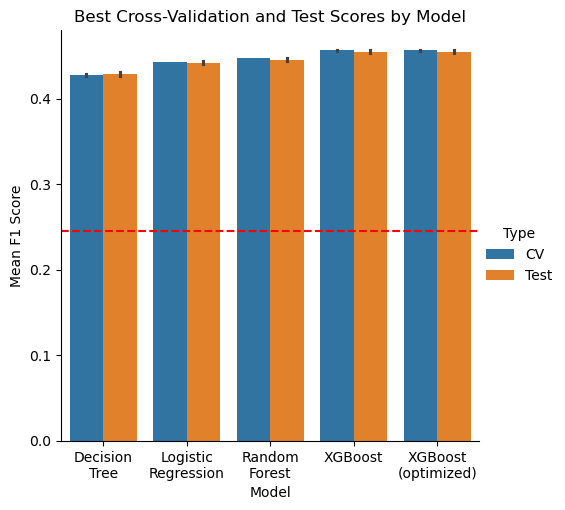

In [19]:
final_scores = {
    "Model" : [],
    "Mean F1 Score" : [],
    "Type" : []
}
# update with model seeds and test scores for that seed
for model, result in final_results.items():
    for cv_score in result["cv_scores"]:
        final_scores["Model"].append(name_sub[model])
        final_scores["Mean F1 Score"].append(cv_score)
        final_scores["Type"].append("CV")
    for test_score in result["test_scores"]:
        final_scores["Model"].append(name_sub[model])
        final_scores["Mean F1 Score"].append(test_score)
        final_scores["Type"].append("Test")

# calculate baseline F1
p1 = y[y==1].shape[0] / y.shape[0]
f1_baseline = 2 * p1 / (1 + p1)

# I am unbelievably lucky that model performance increased alphabetically!
final_scores = pd.DataFrame(final_scores).sort_values("Model")
sns.catplot(data=final_scores, x="Model", y="Mean F1 Score",
            hue="Type", kind="bar")
plt.axhline(f1_baseline, linestyle="--", color="red", label="baseline")
plt.title("Best Cross-Validation and Test Scores by Model")
plt.savefig("../figures/cv_test_scores.png", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

*Ideal hyperparameters*

In [20]:
for model, result in final_results.items():
    print(f"--------Hyperparameters for {model}--------")
    for i, param_set in enumerate(result["params"]):
        print(f"Seed : {result["seed"][i]}")
        for param, val in param_set.items():
            if "xgb" not in model:
                param = param.split("__")[1]
            print(f"{param} : {val}")

--------Hyperparameters for logreg--------
Seed : 7
C : 10.0
l1_ratio : 0.1
Seed : 42
C : 0.001
l1_ratio : 0.1
Seed : 65
C : 0.01
l1_ratio : 0.1
Seed : 2004
C : 0.01
l1_ratio : 0.7000000000000001
Seed : 2026
C : 10.0
l1_ratio : 0.9
--------Hyperparameters for rf--------
Seed : 7
max_depth : 10
max_features : 0.30000000000000004
Seed : 42
max_depth : 10
max_features : 0.7000000000000001
Seed : 65
max_depth : 10
max_features : 0.30000000000000004
Seed : 2004
max_depth : 10
max_features : 0.30000000000000004
Seed : 2026
max_depth : 10
max_features : 0.7000000000000001
--------Hyperparameters for dt--------
Seed : 7
max_depth : 10
max_features : 0.5
Seed : 42
max_depth : 10
max_features : 0.5
Seed : 65
max_depth : 10
max_features : 0.5
Seed : 2004
max_depth : 10
max_features : 0.7000000000000001
Seed : 2026
max_depth : 10
max_features : 0.9
--------Hyperparameters for xgb--------
Seed : 7
max_depth : 50
reg_lambda : 10.0
n_estimators : 99
Seed : 42
max_depth : 50
reg_lambda : 10.0
n_estima

*Reproduce/verify model predictions*

In [21]:
# reproduce model predictions for each set
# and save to master .csv

# same random states as always
random_states = [7, 42, 65, 2004, 2026]

for i, rs in enumerate(random_states):

    # copy to avoid mutating X, y
    X_copy = X.copy(deep=True)
    y_copy = y.copy(deep=True)

    # get true labels
    X_copy["true"] = y_copy

    # for use later
    features = X.columns

    # reproduce cv/test sets
    X_cv, X_test, y_cv, y_test = train_test_split(X_copy, y_copy, stratify=y, test_size=0.2, random_state=rs)

    # indicate which points are test and cv
    X_copy.loc[X_cv.index,"set"] = "cv"
    X_copy.loc[X_test.index,"set"] = "test"

    # repredict all points with saved models
    for model_name, result in final_results.items():

        # find model for this random state
        pipeline = result["models"][i]

        # get predictions for all points
        X_copy[f"{model_name}_pred"] = pipeline[1].predict(pipeline[0].transform(X_copy[features]))

        # very important reproducibility check
        test_points = X_copy[X_copy["set"] == "test"]
        score = f1_score(test_points["true"], test_points[f"{model_name}_pred"])
        print(f"Validated test score of {score:.3f}")
        assert score == result["test_scores"][i]

    X_copy.to_csv(f"../results/seed_{rs}_predictions.csv", index=False)

Validated test score of 0.444
Validated test score of 0.447
Validated test score of 0.426
Validated test score of 0.457
Validated test score of 0.457
Validated test score of 0.441
Validated test score of 0.444
Validated test score of 0.428
Validated test score of 0.454
Validated test score of 0.454
Validated test score of 0.439
Validated test score of 0.443
Validated test score of 0.426
Validated test score of 0.453
Validated test score of 0.453
Validated test score of 0.444
Validated test score of 0.445
Validated test score of 0.433
Validated test score of 0.453
Validated test score of 0.453
Validated test score of 0.443
Validated test score of 0.447
Validated test score of 0.431
Validated test score of 0.457
Validated test score of 0.457


*Confusion matrices*

Model: logreg
F1 scores from CM: [0.44385202 0.44053478 0.43856933 0.44427105 0.4433939 ]
F1 scores saved: [0.44385202 0.44053478 0.43856933 0.44427105 0.4433939 ]
Model: rf
F1 scores from CM: [0.44708896 0.44426087 0.44307591 0.44536915 0.44741763]
F1 scores saved: [0.44708896 0.44426087 0.44307591 0.44536915 0.44741763]
Model: dt
F1 scores from CM: [0.42563051 0.42808098 0.42566402 0.43259597 0.43097022]
F1 scores saved: [0.42563051 0.42808098 0.42566402 0.43259597 0.43097022]
Skipping xgb in favor of optimized version...
Model: xgb_opt
F1 scores from CM: [0.45668714 0.45429134 0.45263781 0.4532785  0.45715345]
F1 scores saved: [0.45668714 0.45429134 0.45263781 0.4532785  0.45715345]


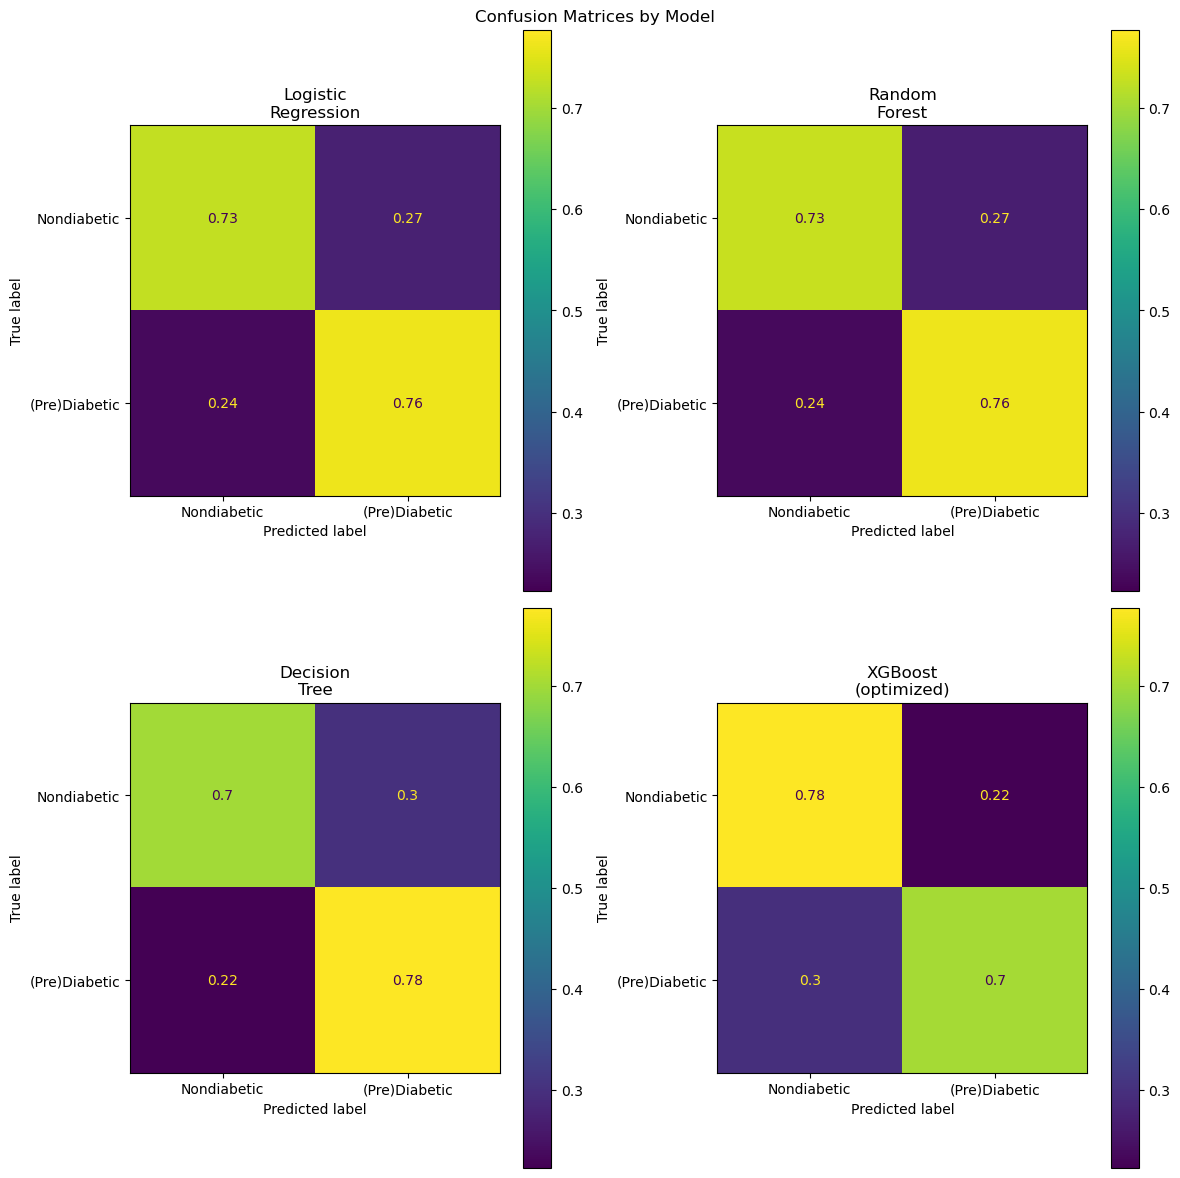

In [22]:
# calculate confusion matrices on all test sets

min_obs = None
max_obs = None
confusion_matrices = []
random_states = [7, 42, 65, 2004, 2026]
for model_name, result in final_results.items():

    if model_name == "xgb":
        print(f"Skipping {model_name} in favor of optimized version...")
        continue

    model_cms = []
    f1s = []
    for rs, model in zip(random_states, result["models"]):

        # reproduce test set
        seed_df = pd.read_csv(f"../results/seed_{rs}_predictions.csv")
        test_set = seed_df[seed_df["set"] == "test"]
        y_test_pred = test_set[f"{model_name}_pred"]
        y_test = test_set[f"true"]
        
        # create confusion matrix for this seed
        cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
        model_cms.append(cm)
        p = cm[1,1] / (cm[0,1] + cm[1,1])
        r = cm[1,1] / (cm[1,0] + cm[1,1])
        f1s.append(2*p*r / (p + r))

    # verify f1 score
    print(f"Model: {model_name}")
    print(f"F1 scores from CM: {np.array(f1s)}")
    print(f"F1 scores saved: {np.array(result["test_scores"])}")

    # average confusion matrices over seeds
    mean_matrix = np.mean(model_cms, axis=0)

    # normalize w.r.t. true conditions
    mean_norm_matrix = np.array([x / np.sum(x) for x in mean_matrix])

    # update minimum and maximum values if necessary
    # this allows normalization for all confusion matrices
    if min_obs is None or np.min(mean_norm_matrix) < min_obs:
        min_obs = np.min(mean_norm_matrix)
    if max_obs is None or np.max(mean_norm_matrix) > max_obs:
        max_obs = np.max(mean_norm_matrix)
    
    # store mean normalized confusion matrix
    confusion_matrices.append((model_name, mean_norm_matrix))

# to normalize colorbars
norm = Normalize(vmin=min_obs, vmax=max_obs)

# make plot
fig, axes = plt.subplots(2,2,figsize=(12,12))
for ax, (model_name, cm) in zip(axes.flatten(), confusion_matrices):

    # plot confusion matrix for this model
    disp = ConfusionMatrixDisplay(cm, display_labels=["Nondiabetic", "(Pre)Diabetic"])
    disp.plot(ax=ax)
    disp.im_.set_norm(norm)
    ax.set_title(name_sub[model_name])
plt.suptitle("Confusion Matrices by Model")
plt.tight_layout()
plt.savefig("../figures/confusion_matrix.png", dpi=300)
plt.show()
plt.close()

### Interpretation

*Global feature importances*

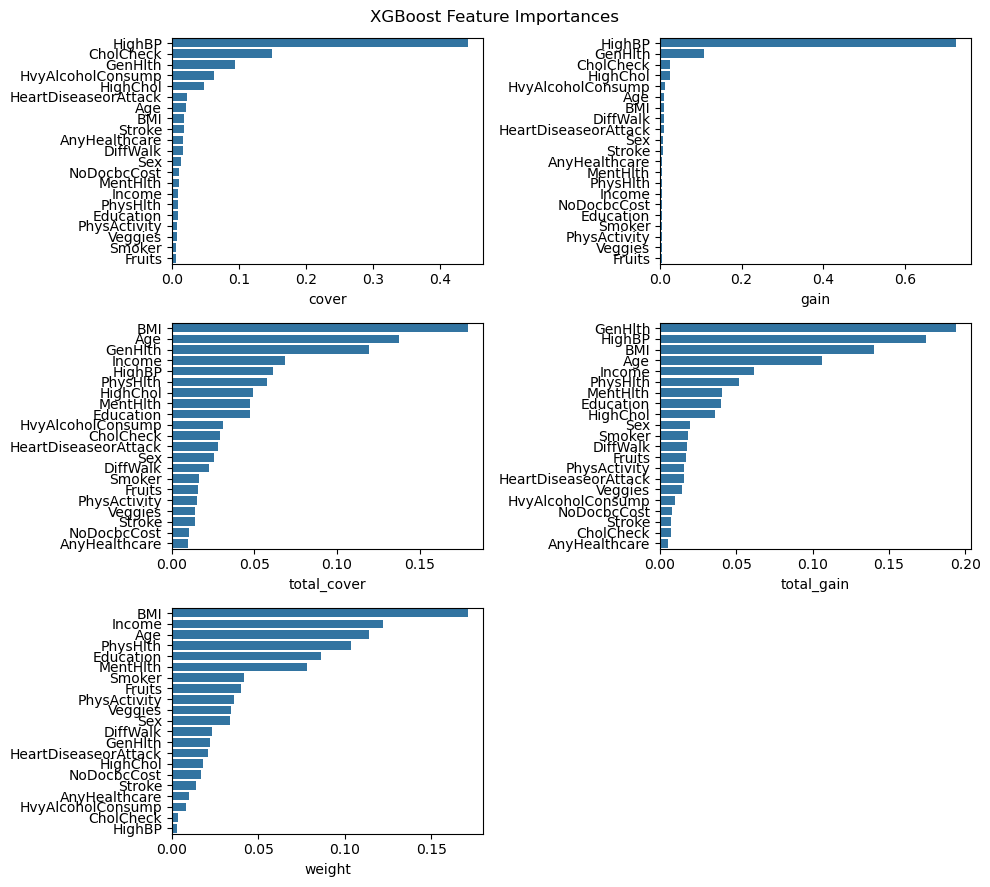

In [23]:
fig, axes = plt.subplots(3,2,figsize=(5*2,3*3))
importance_results = {}
imp_types = ["cover", "gain", "total_cover", "total_gain", "weight"]
for ax, imp_type in zip(axes.flatten(), imp_types):
    imps = []
    for pipeline in final_results["xgb_opt"]["models"]:
        xgb_model = pipeline[1]
        xgb_model.importance_type = imp_type
        imps.append(xgb_model.feature_importances_)
    avg_imps = np.mean(imps, axis=0)
    importance_results[imp_type] = avg_imps
    imp_df = pd.DataFrame(importance_results, index=X.columns)
    sns.barplot(data=imp_df[imp_type].sort_values(ascending=False), orient="h", ax=ax)
axes[-1,-1].remove()
plt.suptitle("XGBoost Feature Importances")
plt.tight_layout()
plt.savefig("../figures/xgb_feature_importances.png", dpi=300)
plt.show()
plt.close()

*Local feature importances*

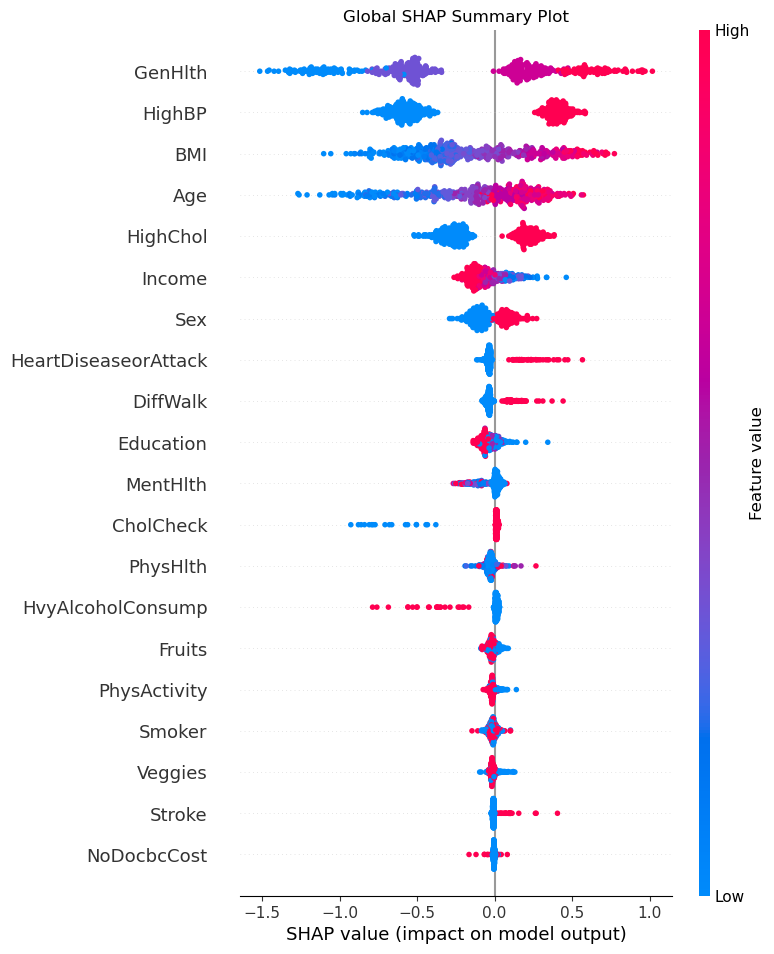

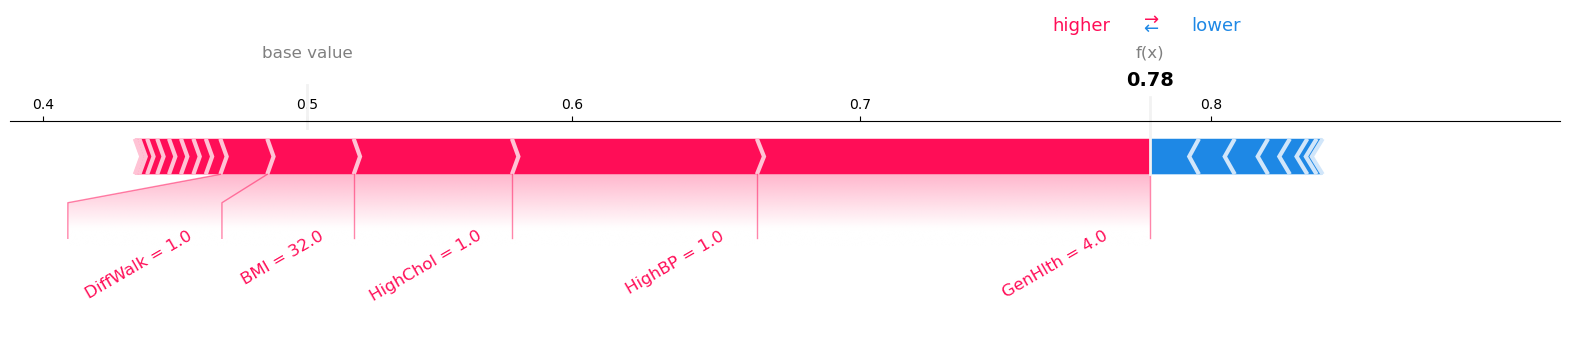

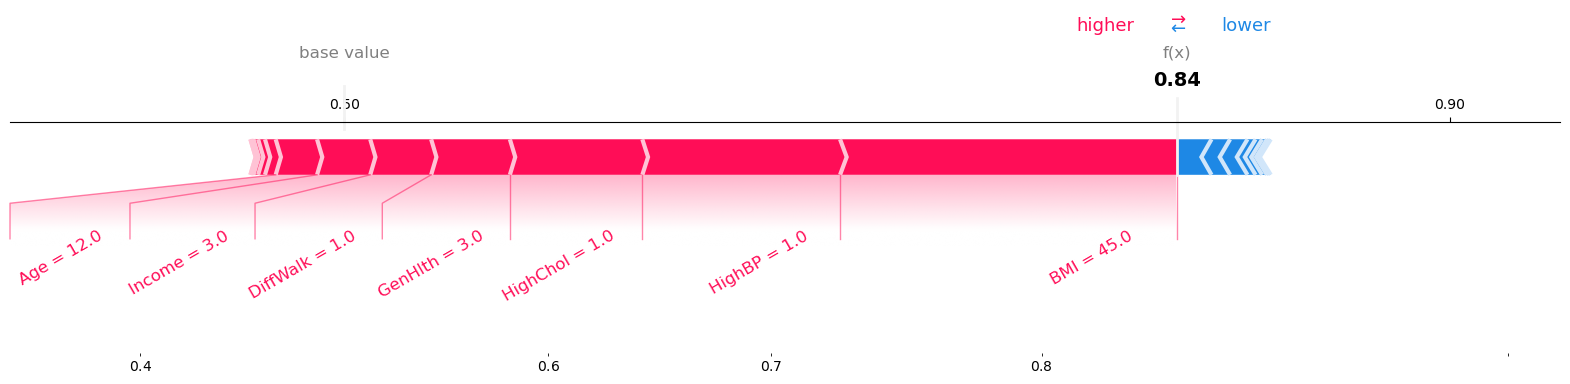

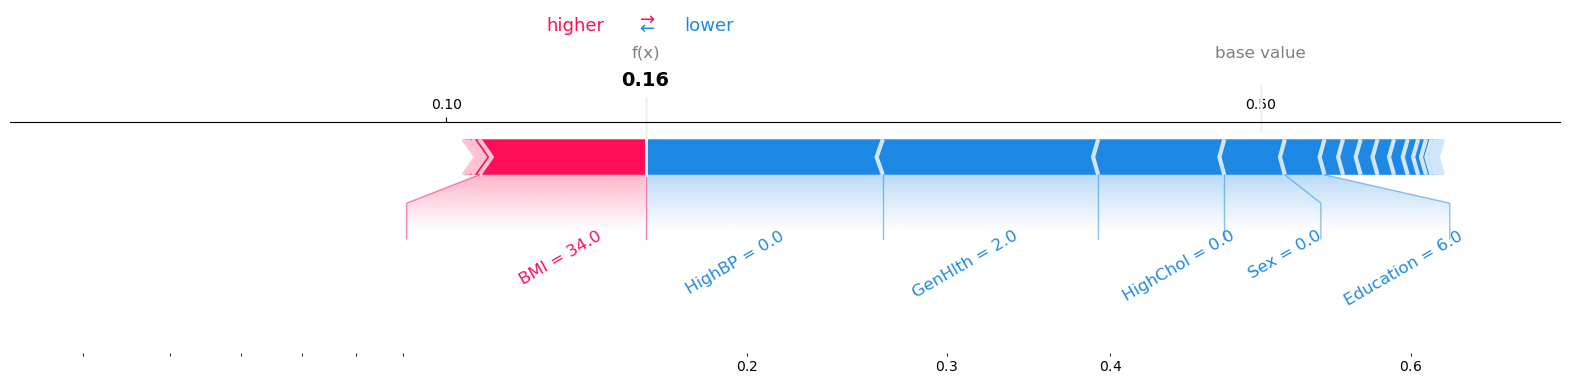

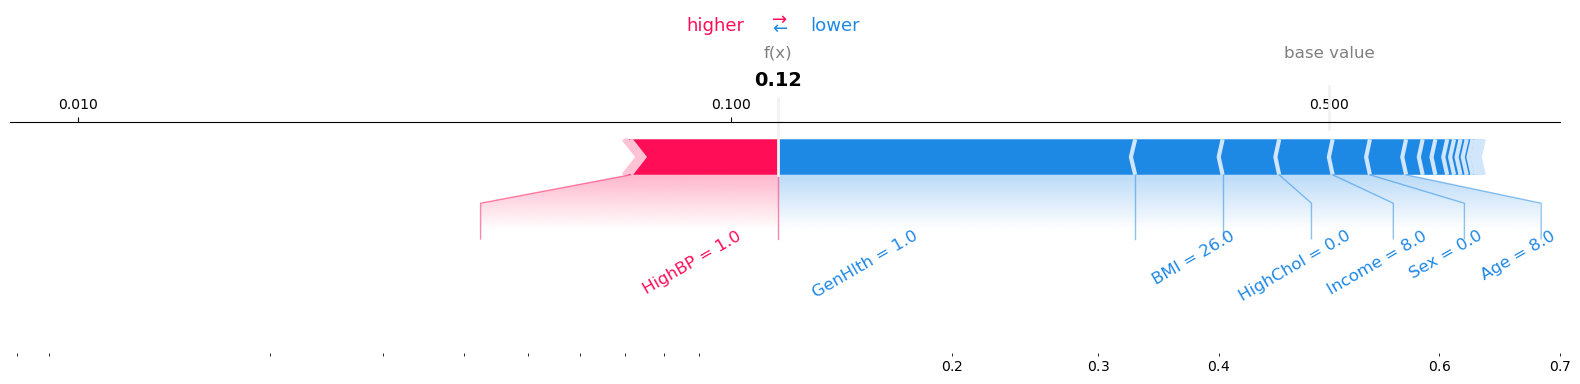

In [24]:
best_model_i = np.argmax(final_results["xgb_opt"]["test_scores"])
rs = final_results["xgb_opt"]["seed"][best_model_i]
pipeline = final_results["xgb_opt"]["models"][best_model_i]
    
# get relevant preprocessor/XGBClassifier
prep = pipeline[0]
xgb_model = pipeline[1]

# reproduce test set
seed_df = pd.read_csv(f"../results/seed_{rs}_predictions.csv")

test_set = seed_df[seed_df["set"] == "test"]
X_test = test_set[X.columns]
y_test_pred = test_set["xgb_opt_pred"]

# sample 1000 points for global SHAP summary plot
_, X_sample, _, _ = train_test_split(X_test, y_test_pred, test_size=0.01, stratify=y_test_pred, random_state=65)

# scale appropriately
X_sample_scaled = prep.transform(X_sample)

# make explainer
exp = shap.TreeExplainer(xgb_model)

# find shap values
sample_shap_vals = exp.shap_values(X_sample_scaled)

# plot
shap.summary_plot(sample_shap_vals, X_sample, feature_names=X_sample.columns, show=False)
plt.title("Global SHAP Summary Plot")
plt.savefig("../figures/global_shap_1percent.png", dpi=300)
plt.show()
plt.close()
    
# find one random point from each class
X_pos_sample = X_test[y_test_pred == 1].sample(n=2, random_state=65)
X_neg_sample = X_test[y_test_pred == 0].sample(n=2, random_state=65)

# combine into one sample
X_sample = pd.concat([X_pos_sample, X_neg_sample])

# scale data appropriately
X_sample_scaled = prep.transform(X_sample)

# get base value
exp = shap.TreeExplainer(xgb_model)
base_val = exp.expected_value

# find SHAP values
sample_shap_vals = exp.shap_values(X_sample_scaled)

for i in range(X_sample.shape[0]):
    plt.close() # extra safe - I had lots of weird bugs with making force plots
    fp = shap.force_plot(base_value=base_val, shap_values=sample_shap_vals[i],
                         features=X_sample.iloc[i], feature_names=X_sample.columns,
                         link="logit", matplotlib=True, show=False, text_rotation=30)
    plt.savefig(f"../figures/shap_{i}.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()